# DCA Ingest - Gantenbein - Gramzio Kohler Server
Dieses Notebook dient dem Einlesen, analysieren und exportieren von Daten des Digitalen Konstruktionsarchivs
Im ersten Schritt werden die Daten eines Verzeichnisses mithilfe von DROID analysiert.
Anschliessend können die Daten individuell analysiert werden.
Im letzten Schritt wird diese Analyse in RDF form festgehalten und zusammen mit den Metadaten des digitalen Materials exportiert.

## Imports und Setup

In [4]:
%pip install pandas matplotlib pywaffle seaborn rdflib ipywidgets pyshacl
import os
import subprocess
import sys
import pandas as pd
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Konfiguration

Hier werden alle Pfade und Parameter definiert.

In [5]:
# Pfad zum Datenset definieren
project_path = "WeingutGantenbein"
# Datenset (zu analysiernder Ordner) definieren
dataset_to_analyze = "gramazio-kohler-archiv-server"

# Dynamisches Home-Verzeichnis
home_dir = os.path.expanduser("~")
base_path = os.path.join(home_dir, "work")

# Pfade
droid_script_path = os.path.join(base_path, "27_DCA_Ingest/src/droid-binary-6.7.0-bin/droid.sh")
folder_to_analyze = os.path.join(base_path, f"dcaonnextcloud-500gb/DigitalMaterialCopies/{project_path}/{dataset_to_analyze}")
output_folder = os.path.join(base_path, f"dcaonnextcloud-500gb/dca-metadataraw/{project_path}/{dataset_to_analyze}_results")
output_csv_path = os.path.join(output_folder, f"{dataset_to_analyze}_DROIDresults.csv")

# Pfad zu src/ hinzufügen, um lokale Module zu importieren
src_path = os.path.join(base_path, "27_DCA_Ingest/src")
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"Analyzing folder: {folder_to_analyze}")
print(f"Output will be saved to: {output_csv_path}")

Analyzing folder: /home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server
Output will be saved to: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/gramazio-kohler-archiv-server_DROIDresults.csv


## DROID-Analyse ausführen

Führt die DROID-Analyse auf dem konfigurierten Ordner aus.

In [6]:
try:
    # Output-Ordner erstellen (falls nicht vorhanden)
    os.makedirs(output_folder, exist_ok=True)

    print(f"Analyzing folder: {folder_to_analyze}")
    print(f"Output will be saved to: {output_csv_path}")

    # DROID-Skript ausführen mit "best match only"
    result = subprocess.run(
        [
            droid_script_path,
            "-R", folder_to_analyze,
            "-o", output_csv_path,
            "-Pr", "profile.generateHash=true",
            "-ff", "file_name not startswith ~$"
        ],
        check=True,
        capture_output=True,
        text=True
    )

    print("DROID output:", result.stdout)
    print(f"Analysis complete. The result is saved in {output_csv_path}.")

except subprocess.CalledProcessError as e:
    print(f"An error occurred while running DROID: {e}")
    print("DROID error output:", e.stderr)

except PermissionError as e:
    print(f"Permission error: {e}")
    print("Bitte prüfe, ob du Schreibrechte für den Zielordner hast.")

except FileNotFoundError as e:
    print(f"Datei oder Verzeichnis nicht gefunden: {e}")
    print("Bitte prüfe, ob alle Pfade korrekt sind und existieren.")

Analyzing folder: /home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server
Output will be saved to: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/gramazio-kohler-archiv-server_DROIDresults.csv


KeyboardInterrupt: 

## Analyse der DROID-Ergebnisse

Die folgenden Zellen führen verschiedene Analysen auf den DROID-Ergebnissen durch.

In [7]:
# Pfade für die Analyse konfigurieren
# CSV_PATH: Pfad zur DROID-Ausgabe-CSV
if "output_csv_path" in locals():
    CSV_PATH = output_csv_path
else:
    # Fallback, falls output_csv_path nicht definiert wurde
    CSV_PATH = os.path.join(base_path, f"dcaonnextcloud-500gb/dca-metadataraw/Semiramis/{dataset_to_analyze}_results/analysis_result.csv")

# OUTPUT_DIR: Verzeichnis für Analyse-Ausgaben
OUTPUT_DIR = os.path.join(output_folder, "res")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"CSV-Datei für Analyse: {CSV_PATH}")
print(f"Ausgabeverzeichnis für Plots: {OUTPUT_DIR}")

CSV-Datei für Analyse: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/gramazio-kohler-archiv-server_DROIDresults.csv
Ausgabeverzeichnis für Plots: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/res


Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/res/format_counts.png


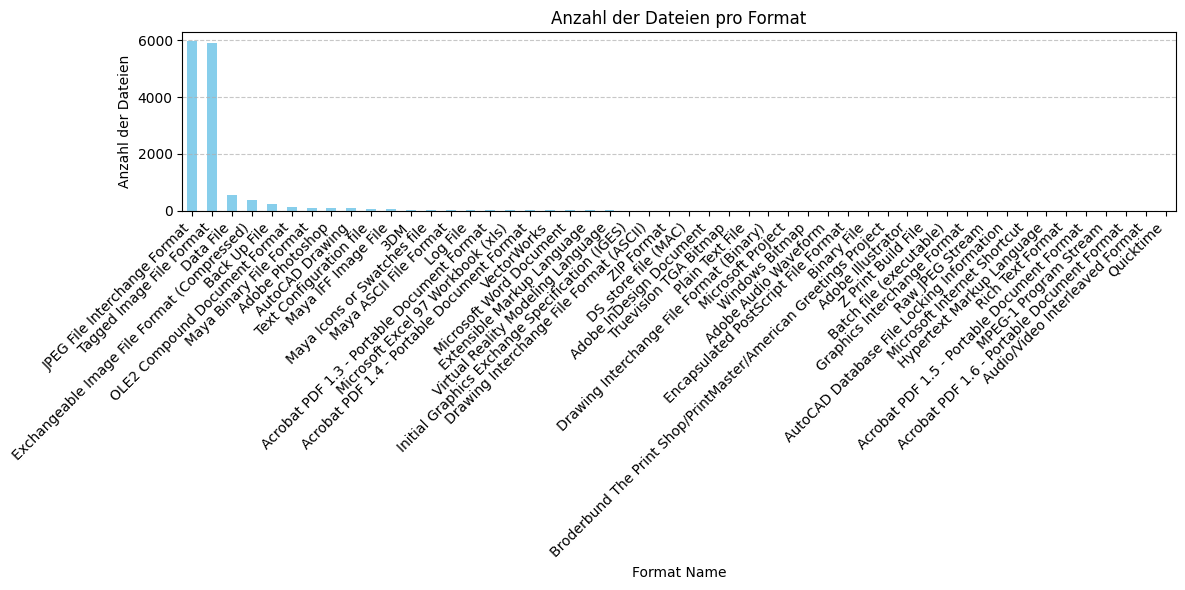

In [5]:
# Analyse: Anzahl der Dateien pro Format
try:
    from analyse_formats import analyse_formats
    analyse_formats(CSV_PATH, OUTPUT_DIR, show_plot=False)
except ImportError:
    print("Hinweis: analyse_formats Modul nicht gefunden. Überspringe diese Analyse.")
except FileNotFoundError as e:
    print(f"Datei nicht gefunden: {e}")
except Exception as e:
    print(f"Fehler bei analyse_formats: {e}")

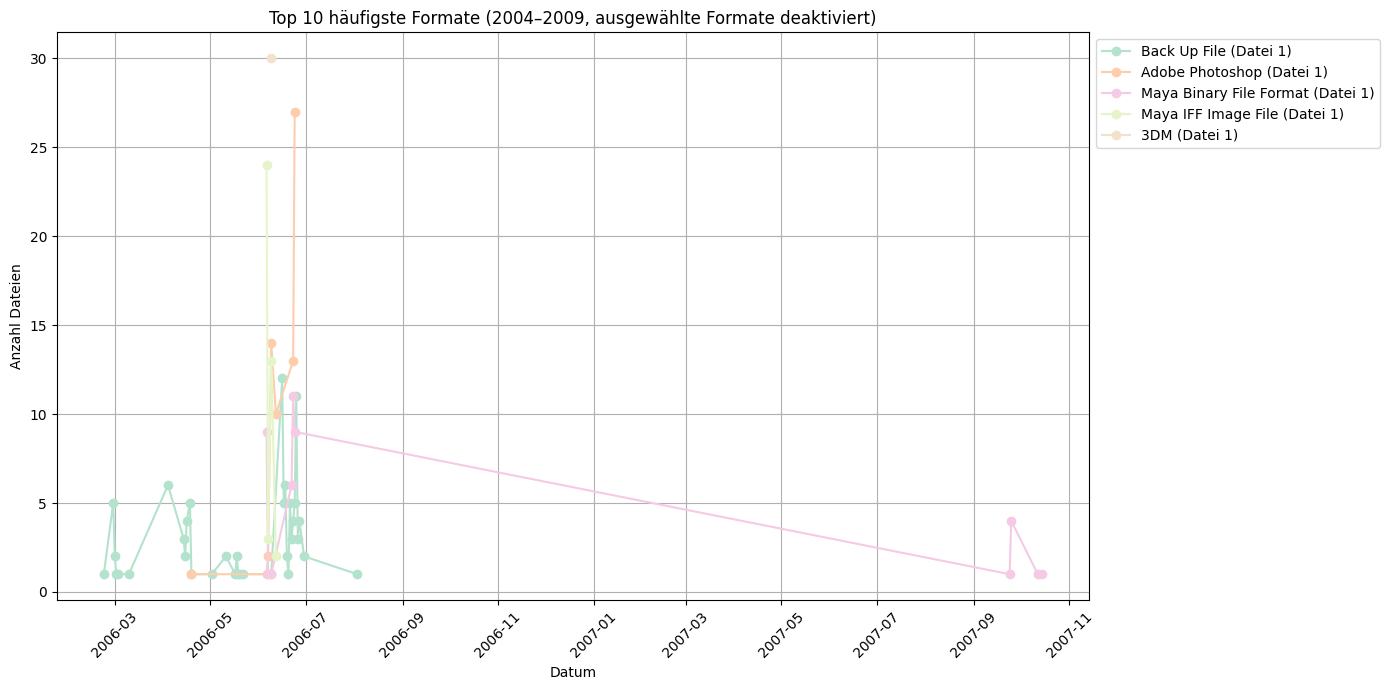

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def analyse_sel_formats(csv_path, output_dir=None, show_plot=True):

    # Konfigurierbare Ausschlussliste
    deaktivierte_formate = {
        "Windows Bitmap",
        "JPEG File Interchange Format",
        "Tagged Image File Format",
        "ZIP Format",
        "Acrobat PDF 1.3 - Portable Document Format",
        "Acrobat PDF 1.4 - Portable Document Format",
        "Acrobat PDF 1.6 - Portable Document Format"
    }
    
    # Start- und Enddatum
    startjahr = 2006
    endjahr = 2007

    # CSV-Dateien einlesen
    df = pd.read_csv(csv_path)

    # Spalte 'LAST_MODIFIED' in datetime umwandeln
    df['LAST_MODIFIED'] = pd.to_datetime(df['LAST_MODIFIED'], errors='coerce')


    # Zeitraum filtern: nur Daten von 2004 bis 2009
    df = df[(df['LAST_MODIFIED'].dt.year >= startjahr) & (df['LAST_MODIFIED'].dt.year <= endjahr)]

    # Optional: Formate ausschließen
    df = df[~df['FORMAT_NAME'].isin(deaktivierte_formate)]

    # Die 5 häufigsten Formate in beiden Dateien ermitteln
    top_formats = df['FORMAT_NAME'].value_counts().nlargest(5).index

    # Plot vorbereiten
    plt.figure(figsize=(14, 7))

    # Farben für Datei 1 (Blau-Schattierung)
    #colors1 = plt.cm.Blues_r(range(50, 50 + 20 * len(top_formats1), 20))
    pastel2 = plt.get_cmap("Pastel2")

    # Farben für Datei 1
    colors1 = [pastel2(i / len(top_formats)) for i in range(len(top_formats))]


    # Plot für Datei 1
    for i, format_name in enumerate(top_formats):
        format_df = df[df['FORMAT_NAME'] == format_name].copy()
        format_df = format_df.sort_values('LAST_MODIFIED')
        time_series = format_df['LAST_MODIFIED'].dt.date.value_counts().sort_index()
        plt.plot(time_series.index, time_series.values, marker='o', linestyle='-', label=f"{format_name} (Datei 1)", color=colors1[i])



    # Diagramm formatieren
    plt.title("Top 10 häufigste Formate (2004–2009, ausgewählte Formate deaktiviert)")
    plt.xlabel("Datum")
    plt.ylabel("Anzahl Dateien")
    plt.xticks(rotation=45)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("../res/vergleich_top10_formats_bereinigt.png")
    plt.show()
try:
    analyse_sel_formats(CSV_PATH, OUTPUT_DIR, show_plot=False)
except ImportError:
    print("Hinweis: analyse_formats Modul nicht gefunden. Überspringe diese Analyse.")
except FileNotFoundError as e:
    print(f"Datei nicht gefunden: {e}")
except Exception as e:
    print(f"Fehler bei analyse_formats: {e}")

Analysiere zeitliche Verteilung von: JPEG File Interchange Format
Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/res/jpeg file interchange format_time_series.png


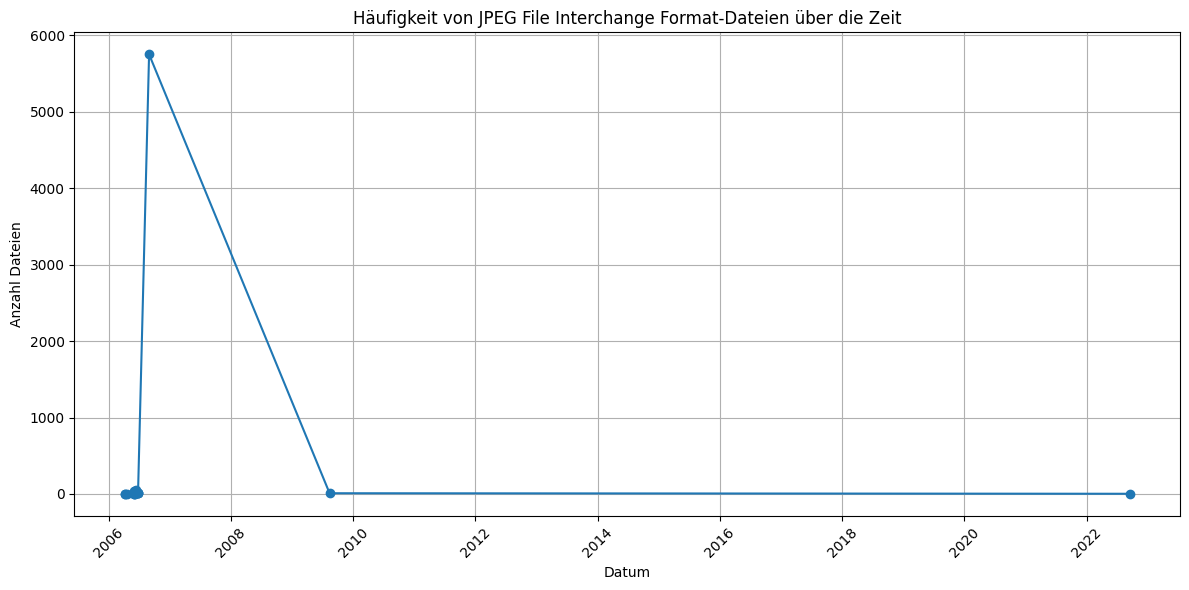

In [6]:
# Analyse: Zeitliche Verteilung eines spezifischen Formats
# Beispiel: Analysiere das häufigste Format über die Zeit
try:
    from analyse_format_last_modified import analyse_format_last_modified
    
    # Ermittle das häufigste Format
    if os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH)
        most_common_format = df["FORMAT_NAME"].value_counts().index[0]
        print(f"Analysiere zeitliche Verteilung von: {most_common_format}")
        analyse_format_last_modified(CSV_PATH, most_common_format, OUTPUT_DIR, show_plot=False)
    else:
        print(f"CSV-Datei nicht gefunden: {CSV_PATH}")
except ImportError:
    print("Hinweis: analyse_format_over_time Modul nicht gefunden. Überspringe diese Analyse.")
except Exception as e:
    print(f"Fehler bei analyse_format_over_time: {e}")

Heatmap für Zeitraum: 1999-2025
Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/res/heatmap_top10_formats_by_month_1999_2025.png


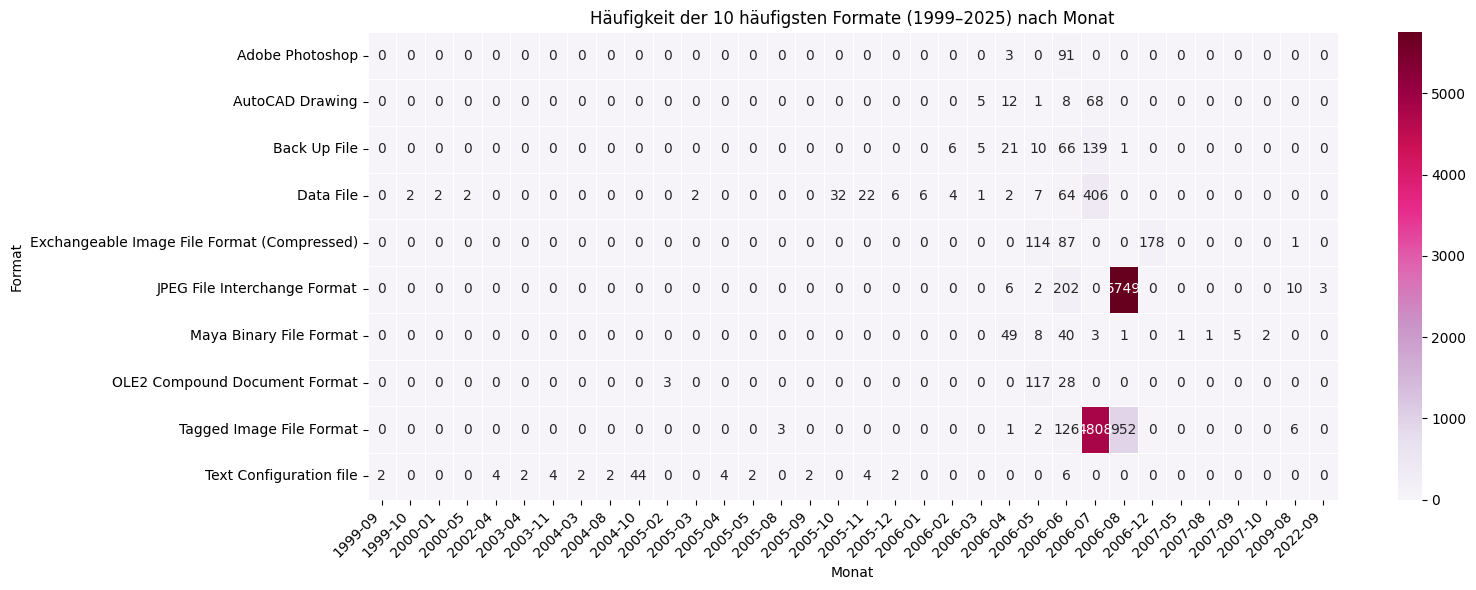

In [7]:
# Analyse: Heatmap der häufigsten Formate nach Monat
try:
    from analyse_format_heatmap import generate_format_heatmap
    
    # Ermittle den Zeitraum aus den Daten
    if os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH)
        df["LAST_MODIFIED"] = pd.to_datetime(df["LAST_MODIFIED"], errors="coerce")
        df_clean = df.dropna(subset=["LAST_MODIFIED"])
        
        if len(df_clean) > 0:
            start_year = df_clean["LAST_MODIFIED"].dt.year.min()
            end_year = df_clean["LAST_MODIFIED"].dt.year.max()
            print(f"Heatmap für Zeitraum: {start_year}-{end_year}")
            generate_format_heatmap(CSV_PATH, OUTPUT_DIR, start_year, end_year, top_n=10, show_plot=False)
        else:
            print("Keine gültigen Datumsangaben in den Daten gefunden.")
    else:
        print(f"CSV-Datei nicht gefunden: {CSV_PATH}")
except ImportError as e:
    print(f"Hinweis: Modul nicht gefunden ({e}). Überspringe Heatmap.")
    print("Installieren Sie seaborn falls benötigt: pip install seaborn")
except Exception as e:
    print(f"Fehler bei generate_format_heatmap: {e}")

Waffle-Chart für Zeitraum: 2006-2007
Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/res/waffle_files_per_month_2006_2007.png


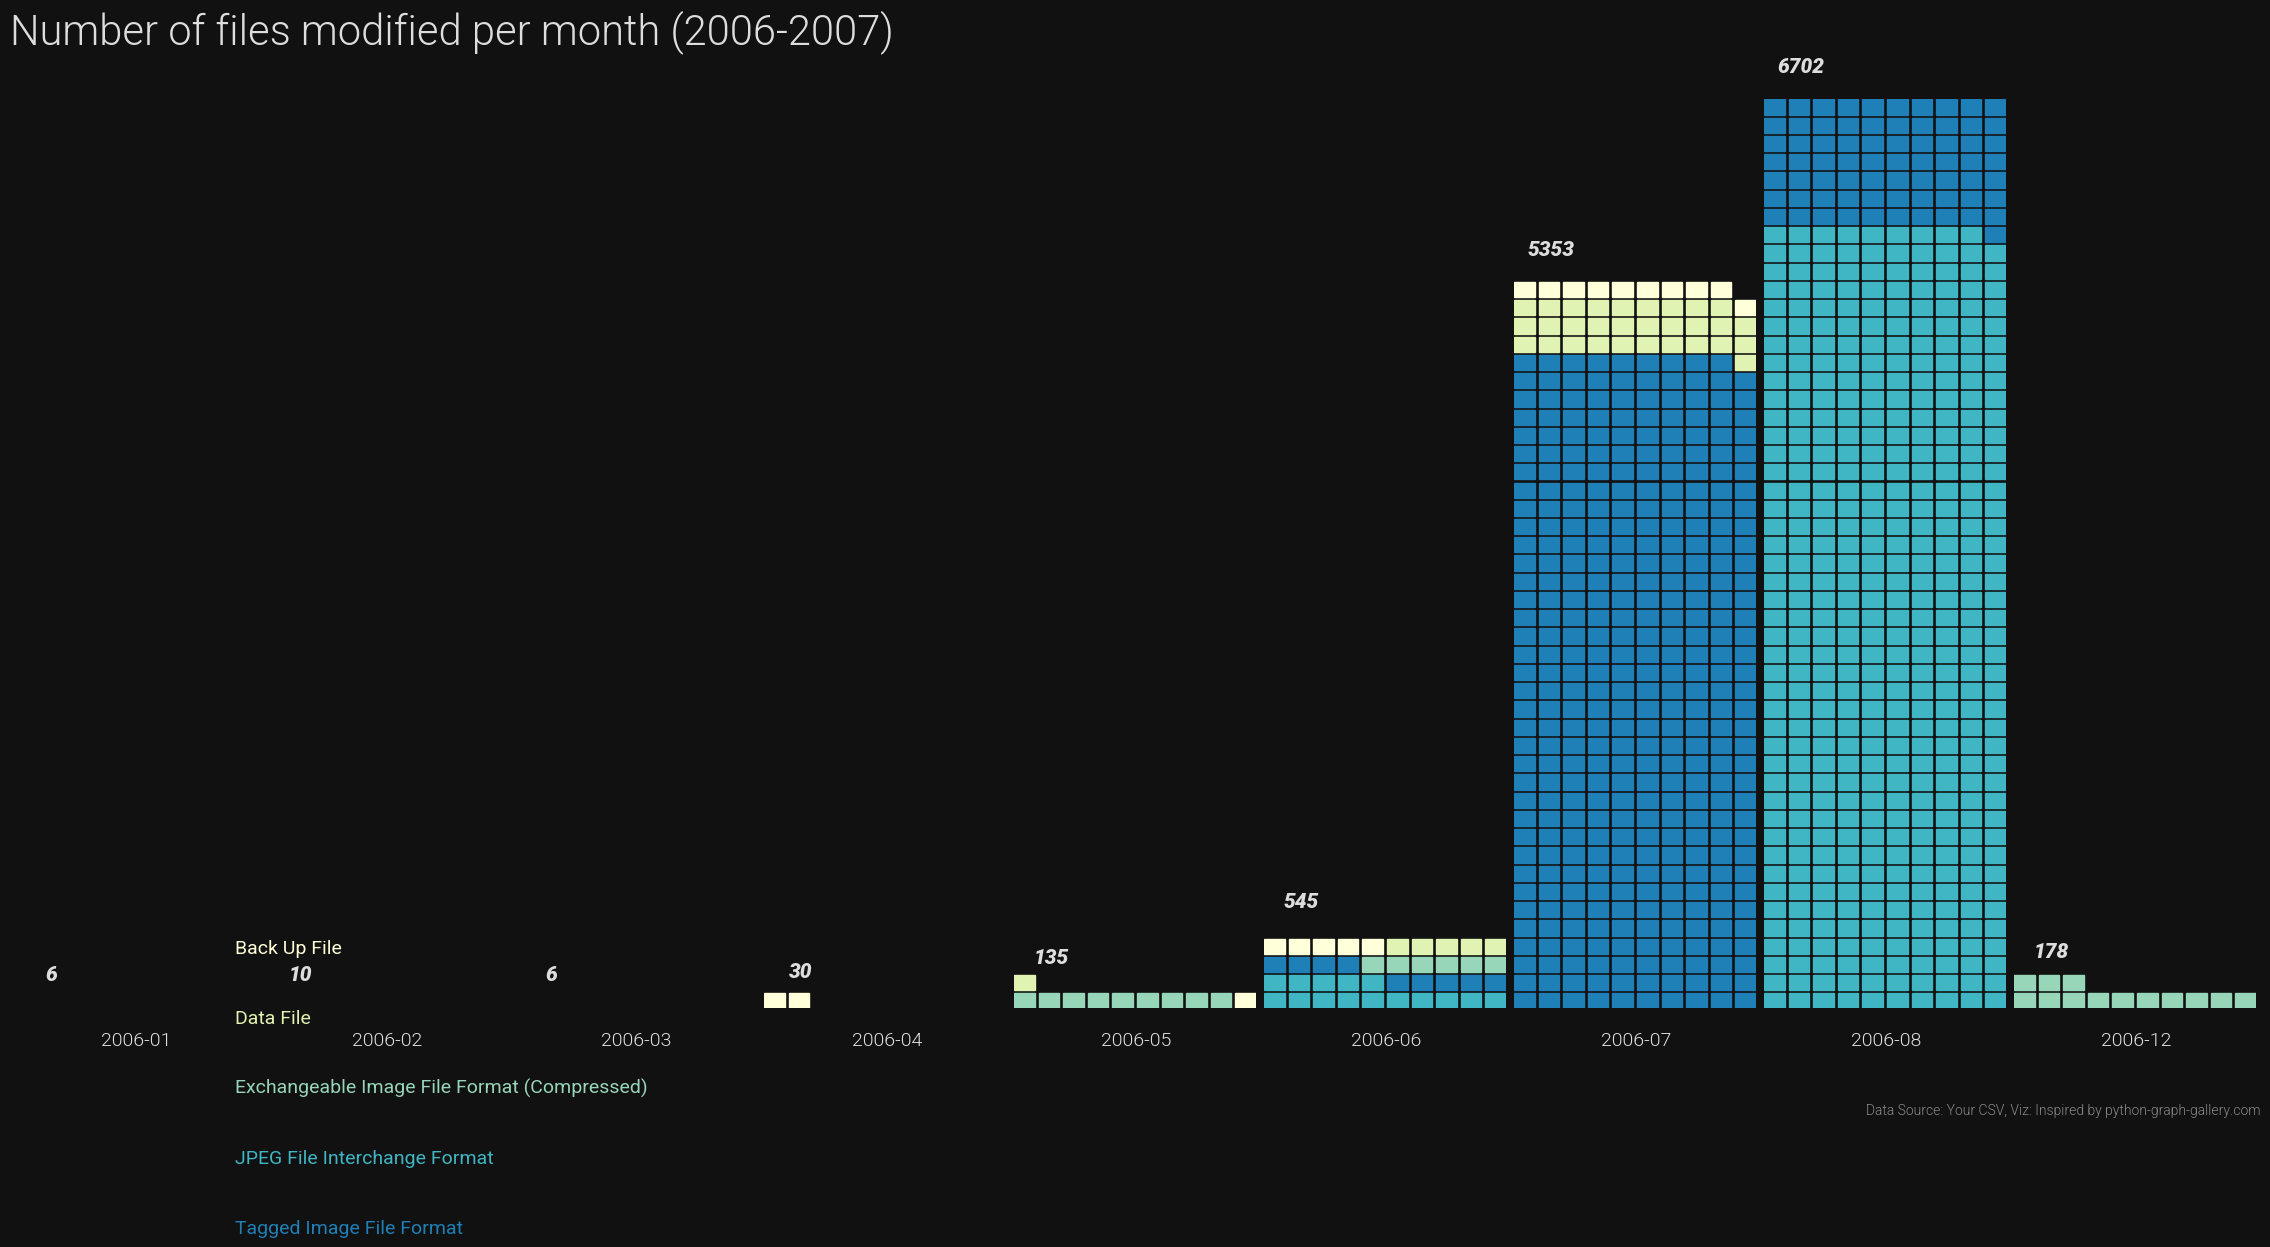

In [8]:
# Analyse: Waffle-Chart für monatliche Dateihäufigkeit

try:
    from generate_waffle import generate_waffle_chart
    
    # Ermittle den Zeitraum aus den Daten
    if os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH)
        df["LAST_MODIFIED"] = pd.to_datetime(df["LAST_MODIFIED"], errors="coerce")
        df_clean = df.dropna(subset=["LAST_MODIFIED"])
        
        if len(df_clean) > 0:
            start_year = 2006
            end_year = 2007
            print(f"Waffle-Chart für Zeitraum: {start_year}-{end_year}")
            
            generate_waffle_chart(
                csv_path=CSV_PATH,
                output_dir=OUTPUT_DIR,
                start_year=start_year,
                end_year=end_year,
                top_n=5,
                show_plot=False,
                date_col="LAST_MODIFIED"
            )

        else:
            print("Keine gültigen Datumsangaben in den Daten gefunden.")
    else:
        print(f"CSV-Datei nicht gefunden: {CSV_PATH}")
except ImportError as e:
    print(f"Hinweis: Modul nicht gefunden ({e}). Überspringe Waffle-Chart.")
    print("Installieren Sie pywaffle falls benötigt: pip install pywaffle")
except Exception as e:
    print(f"Fehler bei generate_waffle_chart: {e}")

## Datenannotation und Export
Im letzten Schritt werden ausgewählte Daten aus der Analyse im RDF Format exportiert. Zusätzlich können Relationen zwischen den Daten erfasst werden.

In [4]:

# ============================================================================
# CRMdig File Relations Cell with SARI Reference Data Model SHACL Validation
# ============================================================================
# This cell provides interactive and programmatic tools for recording
# relations between files using CRMdigital (CRMdig) vocabulary.
# Exports are validated against SARI Reference Data Model using SHACL shapes.

# ============================================================================

# Import the CRMdig RDF module
# Add src path if not already in sys.path
if 'base_path' in locals():
    src_path = os.path.join(base_path, "27_DCA_Ingest/src")
else:
    src_path = os.path.join(os.path.expanduser("~"), "work/27_DCA_Ingest/src")

if src_path not in sys.path:
    sys.path.insert(0, src_path)

from crmdig_rdf import (
    ensure_uids, 
    build_graph_from_dataframe, 
    add_relations_to_graph, 
    save_graph, 
    validate_with_shacl,
    save_validation_report,
    interactive_relation_builder
)

# ============================================================================
# Configuration
# ============================================================================

# Reuse CSV_PATH and OUTPUT_DIR from earlier cells
# (These should be defined in previous notebook cells)
if 'CSV_PATH' not in locals() or 'OUTPUT_DIR' not in locals():
    print("Warning: CSV_PATH and OUTPUT_DIR not found. Using defaults.")
    CSV_PATH = os.path.join(os.path.expanduser("~"), "work/dcaonnextcloud-500gb/dca-metadataraw/Semiramis/2104_mockup_results/analysis_result.csv")
    OUTPUT_DIR = os.path.join(os.path.expanduser("~"), "work/dcaonnextcloud-500gb/dca-metadataraw/Semiramis/2104_mockup_results/res")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set base namespace for RDF URIs
BASE_NS = "http://example.org/dca"

# Set output RDF file path
OUT_RDF = os.path.join(OUTPUT_DIR, "bearth-deplazes-server.ttl")

print(f"CSV Path: {CSV_PATH}")
print(f"Output RDF: {OUT_RDF}")
print(f"Base Namespace: {BASE_NS}")
print("")
print("=" * 70)
print("SARI Reference Data Model Validation Enabled")
print("RDF exports will be validated with SHACL shapes")
print("=" * 70)

# ============================================================================
# Step 1: Ensure Stable UIDs exist in CSV
# ============================================================================

print("\nEnsuring stable UIDs in CSV...")
df = ensure_uids(CSV_PATH, base_ns=BASE_NS, uid_column='uid', inplace=True)
print(f"✓ UIDs ensured for {len(df)} files")

# ============================================================================
# Step 2: Interactive Relation Builder (Jupyter UI)
# ============================================================================
# The interactive UI now includes SHACL validation:
# - "Validate with SHACL" button: Check graph without saving
# - "Save Graph" button: Validates and saves (with validation report if issues found)

# Uncomment the following line to launch the interactive UI:
interactive_relation_builder(CSV_PATH, OUT_RDF, base_ns=BASE_NS, uid_column='uid')

print("\nTo launch the interactive UI, uncomment the line above and run this cell.")

# ============================================================================
# Step 3: Programmatic Example with SHACL Validation
# ============================================================================
# 
# If you prefer to create relations programmatically instead of using the UI,
# uncomment and modify the example below:
#
# # Build graph from CSV
# graph = build_graph_from_dataframe(df, base_ns=BASE_NS, uid_column='uid')
# print(f"Graph initialized with {len(graph)} triples")
#
# # Define relations between files
# # Example: File A is output of Process B, File C derives from File A
# relations = [
#     {
#         "subject_uid": "your-file-uid-1",  # Replace with actual UID from CSV
#         "object_uid": "your-file-uid-2",
#         "predicate": "is output of",
#         "label": "Converted from original scan"
#     },
#     {
#         "subject_uid": "your-file-uid-3",
#         "object_uid": "your-file-uid-1",
#         "predicate": "derives from",
#         "label": "Enhanced version"
#     },
# ]
#
# # Add relations to graph
# add_relations_to_graph(graph, relations, base_ns=BASE_NS)
# print(f"Added {len(relations)} relations to graph")
#
# # Validate graph with SARI SHACL shapes
# print("\nValidating graph against SARI Reference Data Model...")
# conforms, report_graph, report_text = validate_with_shacl(graph, base_ns=BASE_NS)
#
# if conforms:
#     print("✓ SHACL Validation: PASSED")
#     print("  Graph conforms to SARI Reference Data Model")
# else:
#     print("⚠ SHACL Validation: ISSUES FOUND")
#     print(report_text)
#     
#     # Save validation report
#     report_path = os.path.join(OUTPUT_DIR, "validation_report")
#     save_validation_report(report_graph, report_text, report_path)
#     print(f"\nValidation report saved to: {report_path}.txt and {report_path}.ttl")
#
# # Save graph to file (regardless of validation result)
# save_graph(graph, OUT_RDF, format='turtle')
# print(f"\n✓ Graph saved to: {OUT_RDF}")
#
# # Display some triples
# print("\nSample triples:")
# for i, (s, p, o) in enumerate(graph):
#     if i < 10:
#         print(f"  {s} -> {p} -> {o}")
#     else:
#         break

print("\n" + "="*70)
print("CRMdig Relations Cell with SARI SHACL Validation Ready!")
print("Choose one:")
print("1. Uncomment interactive_relation_builder() line to use the UI")
print("2. Uncomment the programmatic example to create relations via code")
print("Both options now include SARI Reference Data Model SHACL validation")
print("="*70)


CSV Path: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/bearth-deplazes-server_results/bearth-deplazes-server_DROIDresults.csv
Output RDF: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/bearth-deplazes-server_results/res/bearth-deplazes-server.ttl
Base Namespace: http://example.org/dca

SARI Reference Data Model Validation Enabled
RDF exports will be validated with SHACL shapes

Ensuring stable UIDs in CSV...
✓ UIDs ensured for 3901 files



To launch the interactive UI, uncomment the line above and run this cell.

CRMdig Relations Cell with SARI SHACL Validation Ready!
Choose one:
1. Uncomment interactive_relation_builder() line to use the UI
2. Uncomment the programmatic example to create relations via code
Both options now include SARI Reference Data Model SHACL validation


In [13]:

# Installation (falls noch nicht vorhanden)
# !pip install rdflib

from rdflib import Graph, Namespace, RDF, RDFS
from rdflib.namespace import DCTERMS

# Pfad zur TTL-Datei
ttl_file = "/home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/bearth-deplazes-server_results/res/relations.ttl"

# RDF-Graph laden
g = Graph()
g.parse(ttl_file, format="turtle")

# SPARQL-Query: Finde alle Subjekte ohne ex:formatName
query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX ex: <http://example.org/dca/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT ?label ?path
WHERE {
    ?s rdfs:label ?label ;
       ex:originalPath ?path .
    FILTER NOT EXISTS { ?s ex:formatName ?format }
}
"""

results = g.query(query)

# Ergebnisse in DataFrame
df = pd.DataFrame([(str(row.label), str(row.path)) for row in results], columns=["Label", "Pfad"])
print(df)



               Label                                               Pfad
0     pdf_2006-02-28  /home/renku/work/dcaonnextcloud-500gb/DigitalM...
1               temp  /home/renku/work/dcaonnextcloud-500gb/DigitalM...
2           SP27.ZEI  zip:/home/renku/work/dcaonnextcloud-500gb/Digi...
3             Rohbau  /home/renku/work/dcaonnextcloud-500gb/DigitalM...
4    Traktandenliste  /home/renku/work/dcaonnextcloud-500gb/DigitalM...
..               ...                                                ...
496          Zwicker  /home/renku/work/dcaonnextcloud-500gb/DigitalM...
497           bauing  /home/renku/work/dcaonnextcloud-500gb/DigitalM...
498        Situation  /home/renku/work/dcaonnextcloud-500gb/DigitalM...
499     Feuerpolizei  /home/renku/work/dcaonnextcloud-500gb/DigitalM...
500       Keller.vwx  /home/renku/work/dcaonnextcloud-500gb/DigitalM...

[501 rows x 2 columns]


In [18]:
pd.set_option('display.max_colwidth', None)
df.iloc[0]

Label                                                                                                                                                                                                  pdf_2006-02-28
Pfad     /home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/bearth-deplazes-server/P_156_2005_Flaesch_Neubau-Erweiterung-Weingut-Gantenbein/CAD/WP_DEF/temp/pdf - planstand/pdf_2006-02-28
Name: 0, dtype: object

In [19]:

# CSV-Datei einlesen
df = pd.read_csv(CSV_PATH)

# Zeilen finden, bei denen FORMAT_NAME fehlt (NaN oder leer)
df_missing_format = df[df["FORMAT_NAME"].isna() | (df["FORMAT_NAME"].str.strip() == "")]

# Volle Anzeige aktivieren
pd.set_option('display.max_colwidth', None)

# Ergebnisse anzeigen
print(df_missing_format)

# Optional: Anzahl der fehlenden Einträge
print(f"Anzahl fehlender FORMAT_NAME: {len(df_missing_format)}")


        ID  PARENT_ID  \
0        1        NaN   
2        3        1.0   
4        5        3.0   
6        7        5.0   
8        9        7.0   
...    ...        ...   
3831  3832     3822.0   
3846  3847     3590.0   
3849  3850     3847.0   
3867  3868     3590.0   
3871  3872     3868.0   

                                                                                                                                                                                                                                             URI  \
0                                                                                                                                     file:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/bearth-deplazes-server/   
2                                                                            file:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/bearth-deplazes-server/P_156_2005_Flaesch_Neubau-Er